In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.inspection import permutation_importance
from keras.optimizers import Adam, RMSprop

In [5]:
## Load Data

df_2019 = pd.read_csv('data/fantasy_data_2019.csv')
df_2020 = pd.read_csv('data/fantasy_data_2020.csv')
df_2021 = pd.read_csv('data/fantasy_data_2021.csv')
df_2022 = pd.read_csv('data/fantasy_data_2022.csv')
df_2023 = pd.read_csv('data/fantasy_data_2023.csv')

In [6]:
## Define and assign Fantasy points

## Calculates Fantasy points for each player in a dataframe
def fantasy_points(df):
  all_points = []
  for i,row in df.iterrows():
    player_points = 0
    player_points += 0.1 * (row['rush_yds'] + row['rec_yds'])
    player_points += 6 * (row['rush_td'] + row['rec_td'])
    player_points += (1/25) * row['pass_yds']
    player_points += (4) * row['pass_td']
    player_points += (-2) * row['int']
    player_points += (-2) * row['fumbles']
    all_points.append(player_points)
  return all_points

df_list = [df_2019, df_2020, df_2021, df_2022, df_2023]
for df in df_list:
  df['fantasy_pts'] = fantasy_points(df)


for i,df in enumerate(df_list):
  if i == 4:
    break
  temp = df_list[i+1].rename(columns = {'fantasy_pts': 'next_yr_pts'})
  df_list[i] = pd.merge(df, temp[['name', 'position', 'next_yr_pts']], on=['name', 'position'], how='inner')

df_2019 = df_list[0]
print(df_2019.columns)
df_2020 = df_list[1]
df_2021 = df_list[2]
df_2022 = df_list[3]

Index(['name', 'position', 'team_pts', 'opp_pts', 'cmp', 'att', 'pass_yds',
       'pass_td', 'int', 'rating', 'sacked', 'rush_att', 'rush_yds', 'rush_td',
       'tgt', 'rec_yds', 'rec_td', 'snap_pct', 'rec', 'age', 'fumbles',
       'games_played', 'yards_per_attempt_qb', 'yards_per_attempt_rb',
       'yards_per_reception_wr', 'fantasy_pts', 'next_yr_pts'],
      dtype='object')


In [7]:
df_full = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True,axis=0)

In [18]:
df_full.columns
df_full['position'].unique()

array(['RB', 'WR', 'QB', 'TE'], dtype=object)

In [23]:
# Assuming df is your input DataFrame

def create_model(optimizer='adam', learning_rate=0.01, activation='relu', neurons=32):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(int(neurons/2), activation=activation))
    model.add(Dense(1))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

Index(['name', 'team_pts', 'opp_pts', 'cmp', 'att', 'pass_yds', 'pass_td',
       'int', 'rating', 'sacked', 'rush_att', 'rush_yds', 'rush_td', 'tgt',
       'rec_yds', 'rec_td', 'snap_pct', 'rec', 'age', 'fumbles',
       'games_played', 'yards_per_attempt_qb', 'yards_per_attempt_rb',
       'yards_per_reception_wr', 'fantasy_pts', 'next_yr_pts', 'position_QB',
       'position_RB', 'position_TE', 'position_WR'],
      dtype='object')
Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=32, model__optimizer=rmsprop; total time=   4.4s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=32, model__optimizer=adam; total time=   4.5s
[CV] END batch_size=10, epochs=100, model__activation=relu, model__learning_rate=0.0001, model__neurons=32, model__optimizer=rmsprop; total time=   4.8s
[CV] END batch_size=10, epochs=100, model_

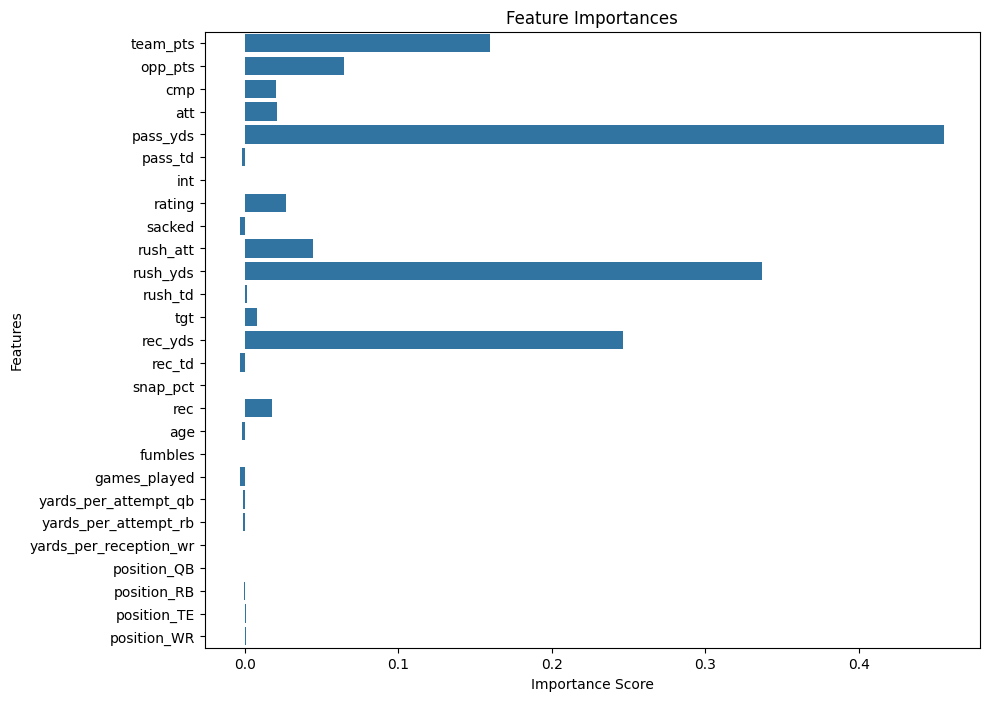

Best Parameters: {'batch_size': 10, 'epochs': 100, 'model__activation': 'relu', 'model__learning_rate': 0.01, 'model__neurons': 256, 'model__optimizer': 'rmsprop'}
RMSE: 78.87170704312058


In [24]:
def process_and_model(df):
    # One-hot encode the 'position' column
    df_encoded = pd.get_dummies(df, columns=['position'], drop_first=False )
    print(df_encoded.columns)
    
    # Define features and target
    X = df_encoded.drop(columns=['name', 'fantasy_pts', 'next_yr_pts'])
    X.fillna(0, inplace = True) 
    y = df_encoded['next_yr_pts']

    global input_dim
    input_dim = X.shape[1]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    # Define the parameter grid for grid search
    param_grid = {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'model__activation': ['relu'],
        'model__neurons': [32, 64, 128,256],
        'batch_size': [10],
        'epochs': [100,200]
    }
    
    # Initialize the model
    model = KerasRegressor(model=create_model, verbose=0)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'RMSE: {rmse}')
    
    # Feature importance: As neural networks do not have direct feature importances, 
    # we can use permutation importance or another method to approximate feature importance.
    result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    
    # Plot variable importance
    feature_importances = pd.Series(result.importances_mean, index=X_train.columns)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    return grid_search.best_params_, rmse

# Assuming df is already defined as your DataFrame
best_params, rmse = process_and_model(df_full)
print(f'Best Parameters: {best_params}')
print(f'RMSE: {rmse}')